In [1]:
# Set environment params
Sys.setenv(LANG='en')  # English

# Import libraries
library(data.table)    # Data manipulate
library(caret)         # ML toolkit
library(mlr)           # ML toolkit
library(party)         # Data processing
library(pROC)          # AUC, ROC
library(rpart)         # Decision tree
library(randomForest)  # Bagging and RF
library(tree)          # CART model
library(gbm)           # Boosting tree
library(class)         # KNN
library(modeest)
library(MASS)
library(MLmetrics)

# Resize plot
library(repr)  # String and binary representations
#options(repr.plot.width=4, repr.plot.height=4)

R.version.string

Loading required package: ggplot2

Loading required package: lattice

Loading required package: ParamHelpers

Warning message: 'mlr' is in 'maintenance-only' mode since July 2019.
Future development will only happen in 'mlr3'
(<https://mlr3.mlr-org.com>). Due to the focus on 'mlr3' there might be
uncaught bugs meanwhile in {mlr} - please consider switching.


Attaching package: 'mlr'


The following object is masked from 'package:caret':

    train


Loading required package: grid

Loading required package: mvtnorm

Loading required package: modeltools

Loading required package: stats4

Loading required package: strucchange

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: sandwich

Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


randomForest 4.6-14

Type rfNews() to

[1] "R version 4.0.5 (2021-03-31)"

In [2]:
credit = read.csv('credit_default_train.csv')
str(credit)

'data.frame':	20000 obs. of  25 variables:
 $ cust_id                   : int  18895 25102 28867 1842 3371 29925 29940 11638 4761 6746 ...
 $ LIMIT_BAL                 : int  70000 390000 60000 140000 50000 20000 50000 250000 320000 300000 ...
 $ SEX                       : int  1 2 1 2 1 1 1 1 2 1 ...
 $ EDUCATION                 : int  3 2 1 2 1 2 3 2 2 1 ...
 $ MARRIAGE                  : int  2 2 2 1 2 2 2 2 2 1 ...
 $ AGE                       : int  34 26 27 55 29 37 44 30 36 35 ...
 $ PAY_0                     : int  0 2 0 0 2 0 0 0 -2 0 ...
 $ PAY_2                     : int  0 2 0 0 2 0 0 0 -2 0 ...
 $ PAY_3                     : int  0 2 0 0 2 0 0 0 -2 0 ...
 $ PAY_4                     : int  0 0 0 0 0 0 2 -1 -2 0 ...
 $ PAY_5                     : int  0 0 0 0 0 0 0 2 -2 0 ...
 $ PAY_6                     : int  0 0 2 0 -2 0 0 -1 -2 0 ...
 $ BILL_AMT1                 : int  53972 185111 21387 108038 7881 20009 NA 5724 29862 91282 ...
 $ BILL_AMT2                 : int  2314

In [3]:
# Show the data
head(credit)

,cust_id,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,18895,70000,1,3,2,34,0,0,0,0,⋯,25559,26134,26715,1700,1500,2000,1000,1000,2000,0
2,25102,390000,2,2,2,26,2,2,2,0,⋯,140387,128112,115514,5000,3000,5000,4548,4100,3300,0
3,28867,60000,1,1,2,27,0,0,0,0,⋯,26038,28607,27997,1378,1406,3000,3000,0,923,1
4,1842,140000,2,2,1,55,0,0,0,0,⋯,72391,61298,62193,4200,2822,2336,2588,2250,2491,0
5,3371,50000,1,1,2,29,2,2,2,0,⋯,1047,0,0,3000,0,1000,0,0,0,1
6,29925,20000,1,2,2,37,0,0,0,0,⋯,19105,19609,19283,1700,1600,1200,1000,900,1000,0


#### 1.1. Split data

In [4]:
# Train test spliting
set.seed(123)
train_idx <- createDataPartition(credit[, 'default.payment.next.month'], p=.7, list=FALSE)

# Train dataset
train <- credit[train_idx, ]

# Test dataset
test <- credit[-train_idx, ]

In [5]:
# Check the data
str(train)

'data.frame':	14000 obs. of  25 variables:
 $ cust_id                   : int  18895 25102 1842 3371 29925 29940 4761 6746 26203 2757 ...
 $ LIMIT_BAL                 : int  70000 390000 140000 50000 20000 50000 320000 300000 500000 80000 ...
 $ SEX                       : int  1 2 2 1 1 1 2 1 1 2 ...
 $ EDUCATION                 : int  3 2 2 1 2 3 2 1 1 2 ...
 $ MARRIAGE                  : int  2 2 1 2 2 2 2 1 1 2 ...
 $ AGE                       : int  34 26 55 29 37 44 36 35 41 29 ...
 $ PAY_0                     : int  0 2 0 2 0 0 -2 0 -1 0 ...
 $ PAY_2                     : int  0 2 0 2 0 0 -2 0 -1 0 ...
 $ PAY_3                     : int  0 2 0 2 0 0 -2 0 -1 0 ...
 $ PAY_4                     : int  0 0 0 0 0 2 -2 0 -2 2 ...
 $ PAY_5                     : int  0 0 0 0 0 0 -2 0 -1 2 ...
 $ PAY_6                     : int  0 0 0 -2 0 0 -2 0 -1 0 ...
 $ BILL_AMT1                 : int  53972 185111 108038 7881 20009 NA 29862 91282 719 59520 ...
 $ BILL_AMT2                 : int  23

In [6]:
# Check the target variable distribution
table(train$default.payment.next.month)


    0     1 
10902  3098 

In [7]:
# Check the data
str(test)

'data.frame':	6000 obs. of  25 variables:
 $ cust_id                   : int  28867 11638 16128 2888 12499 19364 17431 23451 3004 3995 ...
 $ LIMIT_BAL                 : int  60000 250000 90000 20000 30000 80000 100000 30000 50000 100000 ...
 $ SEX                       : int  1 1 2 1 1 2 1 2 2 2 ...
 $ EDUCATION                 : int  1 2 2 1 2 2 3 3 3 2 ...
 $ MARRIAGE                  : int  2 2 2 2 1 2 2 1 1 1 ...
 $ AGE                       : int  27 30 32 38 36 27 32 38 35 35 ...
 $ PAY_0                     : int  0 0 -2 0 1 -1 2 -2 0 -1 ...
 $ PAY_2                     : int  0 0 -2 0 3 0 2 -2 0 -1 ...
 $ PAY_3                     : int  0 0 -2 0 2 0 0 -2 0 -1 ...
 $ PAY_4                     : int  0 -1 -2 0 5 0 0 -2 0 0 ...
 $ PAY_5                     : int  0 2 -2 2 4 0 0 -2 0 0 ...
 $ PAY_6                     : int  2 -1 -2 0 3 0 0 -2 0 -1 ...
 $ BILL_AMT1                 : int  21387 5724 573 16787 18811 45198 103540 1535 49930 29048 ...
 $ BILL_AMT2                 : i

In [8]:
# Check the target variable distribution
table(test$default.payment.next.month)


   0    1 
4684 1316 

#### 1.2a Data Processing (Train)

In [9]:
# List of numerical and catergorical variables
iv_vars <- colnames(train)[2:(ncol(train)-1)]
dv_var <- colnames(train)[ncol(train)]
num_vars <- c('LIMIT_BAL', 'AGE',
            'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
            'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6')
cat_vars <- c('SEX', 'EDUCATION', 'MARRIAGE',
            'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6')

In [10]:
# Check missing values
print(paste("Total NAs:", sum(apply(is.na(train[iv_vars]), 2, sum))))
apply(is.na(train[iv_vars]), 2, sum)

[1] "Total NAs: 3159"


LIMIT_BAL       SEX EDUCATION  MARRIAGE       AGE     PAY_0     PAY_2     PAY_3 
      143       114       147       120       160       133       150       152 
    PAY_4     PAY_5     PAY_6 BILL_AMT1 BILL_AMT2 BILL_AMT3 BILL_AMT4 BILL_AMT5 
      147       131       145       136       141       124       116       132 
BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6 
      151       141       128       149       127       133       139

In [11]:
# Calculating the median of num_vars
a <- median(train$LIMIT_BAL, na.rm=TRUE)
b <- median(train$AGE, na.rm=TRUE)
c <- median(train$BILL_AMT1, na.rm=TRUE)
d <- median(train$BILL_AMT2, na.rm=TRUE)
e <- median(train$BILL_AMT3, na.rm=TRUE)
f <- median(train$BILL_AMT4, na.rm=TRUE)
g <- median(train$BILL_AMT5, na.rm=TRUE)
h <- median(train$BILL_AMT6, na.rm=TRUE)
i <- median(train$PAY_AMT1, na.rm=TRUE)
j <- median(train$PAY_AMT2, na.rm=TRUE)
k <- median(train$PAY_AMT3, na.rm=TRUE)
l <- median(train$PAY_AMT4, na.rm=TRUE)
m <- median(train$PAY_AMT5, na.rm=TRUE)
n <- median(train$PAY_AMT6, na.rm=TRUE)

In [12]:
# Filling num_vars with median
train$LIMIT_BAL[is.na(train$LIMIT_BAL)] <- a
train$AGE[is.na(train$AGE)] <- b
train$BILL_AMT1[is.na(train$BILL_AMT1)] <- c
train$BILL_AMT2[is.na(train$BILL_AMT2)] <- d
train$BILL_AMT3[is.na(train$BILL_AMT3)] <- e
train$BILL_AMT4[is.na(train$BILL_AMT4)] <- f
train$BILL_AMT5[is.na(train$BILL_AMT5)] <- g
train$BILL_AMT6[is.na(train$BILL_AMT6)] <- h
train$PAY_AMT1[is.na(train$PAY_AMT1)] <- i
train$PAY_AMT2[is.na(train$PAY_AMT2)] <- j
train$PAY_AMT3[is.na(train$PAY_AMT3)] <- k
train$PAY_AMT4[is.na(train$PAY_AMT4)] <- l
train$PAY_AMT5[is.na(train$PAY_AMT5)] <- m
train$PAY_AMT6[is.na(train$PAY_AMT6)] <- n

In [13]:
# Calculating the mode of cat_vars
o <- mlv(train$SEX, method = "mfv")
p <- mlv(train$EDUCATION, method = "mfv")
q <- mlv(train$MARRIAGE, method = "mfv")
r <- mlv(train$PAY_0, method = "mfv")
s <- mlv(train$PAY_2, method = "mfv")
t <- mlv(train$PAY_3, method = "mfv")
u <- mlv(train$PAY_4, method = "mfv")
v <- mlv(train$PAY_5, method = "mfv")
w <- mlv(train$PAY_6, method = "mfv")

In [14]:
# Filling cat_vars with mode
train$SEX[is.na(train$SEX)] <- o
train$EDUCATION[is.na(train$EDUCATION)] <- p
train$MARRIAGE[is.na(train$MARRIAGE)] <- q
train$PAY_0[is.na(train$PAY_0)] <- r
train$PAY_2[is.na(train$PAY_2)] <- s
train$PAY_3[is.na(train$PAY_3)] <- t
train$PAY_4[is.na(train$PAY_4)] <- u
train$PAY_5[is.na(train$PAY_5)] <- v
train$PAY_6[is.na(train$PAY_6)] <- w

In [15]:
# turning the target variable into factor
train_f <- train
train_f$default.payment.next.month<-as.factor(train_f$default.payment.next.month)

In [16]:
str(train)
str(train_f)

'data.frame':	14000 obs. of  25 variables:
 $ cust_id                   : int  18895 25102 1842 3371 29925 29940 4761 6746 26203 2757 ...
 $ LIMIT_BAL                 : int  70000 390000 140000 50000 20000 50000 320000 300000 500000 80000 ...
 $ SEX                       : int  1 2 2 1 1 1 2 1 1 2 ...
 $ EDUCATION                 : int  3 2 2 1 2 3 2 1 1 2 ...
 $ MARRIAGE                  : int  2 2 1 2 2 2 2 1 1 2 ...
 $ AGE                       : num  34 26 55 29 37 44 36 35 41 29 ...
 $ PAY_0                     : int  0 2 0 2 0 0 -2 0 -1 0 ...
 $ PAY_2                     : int  0 2 0 2 0 0 -2 0 -1 0 ...
 $ PAY_3                     : int  0 2 0 2 0 0 -2 0 -1 0 ...
 $ PAY_4                     : int  0 0 0 0 0 2 -2 0 -2 2 ...
 $ PAY_5                     : int  0 0 0 0 0 0 -2 0 -1 2 ...
 $ PAY_6                     : int  0 0 0 -2 0 0 -2 0 -1 0 ...
 $ BILL_AMT1                 : num  53972 185111 108038 7881 20009 ...
 $ BILL_AMT2                 : int  23149 172865 110216 10415 2

In [17]:
# Check missing values
print(paste("Total NAs:", sum(apply(is.na(train[iv_vars]), 2, sum))))
apply(is.na(train[iv_vars]), 2, sum)

[1] "Total NAs: 0"


LIMIT_BAL       SEX EDUCATION  MARRIAGE       AGE     PAY_0     PAY_2     PAY_3 
        0         0         0         0         0         0         0         0 
    PAY_4     PAY_5     PAY_6 BILL_AMT1 BILL_AMT2 BILL_AMT3 BILL_AMT4 BILL_AMT5 
        0         0         0         0         0         0         0         0 
BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6 
        0         0         0         0         0         0         0

#### 1.2b Data Processing (Test)

In [18]:
# List of numerical and catergorical variables
iv_vars <- colnames(test)[2:(ncol(test)-1)]
dv_var <- colnames(test)[ncol(test)]
num_vars <- c('LIMIT_BAL', 'AGE',
            'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
            'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6')
cat_vars <- c('SEX', 'EDUCATION', 'MARRIAGE',
            'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6')

In [19]:
# Check missing values
print(paste("Total NAs:", sum(apply(is.na(test[iv_vars]), 2, sum))))
apply(is.na(test[iv_vars]), 2, sum)

[1] "Total NAs: 1289"


LIMIT_BAL       SEX EDUCATION  MARRIAGE       AGE     PAY_0     PAY_2     PAY_3 
       59        47        52        50        54        62        69        65 
    PAY_4     PAY_5     PAY_6 BILL_AMT1 BILL_AMT2 BILL_AMT3 BILL_AMT4 BILL_AMT5 
       52        54        58        49        68        51        49        49 
BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6 
       46        63        56        63        70        46        57

In [20]:
# Filling num_vars with train median
test$LIMIT_BAL[is.na(test$LIMIT_BAL)] <- a
test$AGE[is.na(test$AGE)] <- b
test$BILL_AMT1[is.na(test$BILL_AMT1)] <- c
test$BILL_AMT2[is.na(test$BILL_AMT2)] <- d
test$BILL_AMT3[is.na(test$BILL_AMT3)] <- e
test$BILL_AMT4[is.na(test$BILL_AMT4)] <- f
test$BILL_AMT5[is.na(test$BILL_AMT5)] <- g
test$BILL_AMT6[is.na(test$BILL_AMT6)] <- h
test$PAY_AMT1[is.na(test$PAY_AMT1)] <- i
test$PAY_AMT2[is.na(test$PAY_AMT2)] <- j
test$PAY_AMT3[is.na(test$PAY_AMT3)] <- k
test$PAY_AMT4[is.na(test$PAY_AMT4)] <- l
test$PAY_AMT5[is.na(test$PAY_AMT5)] <- m
test$PAY_AMT6[is.na(test$PAY_AMT6)] <- n

In [21]:
# Filling num_vars with train mode
test$SEX[is.na(test$SEX)] <- o
test$EDUCATION[is.na(test$EDUCATION)] <- p
test$MARRIAGE[is.na(test$MARRIAGE)] <- q
test$PAY_0[is.na(test$PAY_0)] <- r
test$PAY_2[is.na(test$PAY_2)] <- s
test$PAY_3[is.na(test$PAY_3)] <- t
test$PAY_4[is.na(test$PAY_4)] <- u
test$PAY_5[is.na(test$PAY_5)] <- v
test$PAY_6[is.na(test$PAY_6)] <- w

In [22]:
# turning the target variable into factor
test_f <- test
test_f$default.payment.next.month<-as.factor(test_f$default.payment.next.month)

In [23]:
# Check missing values
print(paste("Total NAs:", sum(apply(is.na(test[iv_vars]), 2, sum))))
apply(is.na(test[iv_vars]), 2, sum)

[1] "Total NAs: 0"


LIMIT_BAL       SEX EDUCATION  MARRIAGE       AGE     PAY_0     PAY_2     PAY_3 
        0         0         0         0         0         0         0         0 
    PAY_4     PAY_5     PAY_6 BILL_AMT1 BILL_AMT2 BILL_AMT3 BILL_AMT4 BILL_AMT5 
        0         0         0         0         0         0         0         0 
BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6 
        0         0         0         0         0         0         0

In [24]:
str(test)
str(test_f)

'data.frame':	6000 obs. of  25 variables:
 $ cust_id                   : int  28867 11638 16128 2888 12499 19364 17431 23451 3004 3995 ...
 $ LIMIT_BAL                 : int  60000 250000 90000 20000 30000 80000 100000 30000 50000 100000 ...
 $ SEX                       : int  1 1 2 1 1 2 1 2 2 2 ...
 $ EDUCATION                 : int  1 2 2 1 2 2 3 3 3 2 ...
 $ MARRIAGE                  : int  2 2 2 2 1 2 2 1 1 1 ...
 $ AGE                       : num  27 30 32 38 36 27 32 38 35 35 ...
 $ PAY_0                     : int  0 0 -2 0 1 -1 2 -2 0 -1 ...
 $ PAY_2                     : int  0 0 -2 0 3 0 2 -2 0 -1 ...
 $ PAY_3                     : int  0 0 -2 0 2 0 0 -2 0 -1 ...
 $ PAY_4                     : int  0 -1 -2 0 5 0 0 -2 0 0 ...
 $ PAY_5                     : int  0 2 -2 2 4 0 0 -2 0 0 ...
 $ PAY_6                     : int  2 -1 -2 0 3 0 0 -2 0 -1 ...
 $ BILL_AMT1                 : num  21387 5724 573 16787 18811 ...
 $ BILL_AMT2                 : int  22416 6729 0 17912 18225 4

#### 1.3 Modelling

#### 1.3a Logistic Regression

In [25]:
# Fit Logistic Regression model
md_logreg <- glm(default.payment.next.month ~ ., data=train, family='binomial')
summary(md_logreg)


Call:
glm(formula = default.payment.next.month ~ ., family = "binomial", 
    data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.0795  -0.7043  -0.5527  -0.2882   3.1836  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.690e-01  1.785e-01  -3.187 0.001436 ** 
cust_id     -1.646e-06  2.512e-06  -0.655 0.512242    
LIMIT_BAL   -5.901e-07  2.271e-07  -2.598 0.009376 ** 
SEX         -1.038e-01  4.493e-02  -2.310 0.020873 *  
EDUCATION   -1.044e-01  3.080e-02  -3.389 0.000701 ***
MARRIAGE    -1.378e-01  4.640e-02  -2.971 0.002969 ** 
AGE          3.725e-03  2.615e-03   1.425 0.154290    
PAY_0        5.709e-01  2.608e-02  21.890  < 2e-16 ***
PAY_2        5.683e-02  2.940e-02   1.933 0.053248 .  
PAY_3        6.498e-02  3.268e-02   1.989 0.046734 *  
PAY_4        3.396e-02  3.605e-02   0.942 0.346282    
PAY_5        6.879e-02  3.847e-02   1.788 0.073776 .  
PAY_6       -1.245e-02  3.220e-02  -0.387 0.698917    
BILL_AMT

#### 1.4a Feature Selection - Logistic Regression

In [26]:
# Feature selection of the model for logistic regression
# Choose the p-value < 0.05, further choose it until all p-value of the selected features are < 0.05
# Fit logistic regression model with only signiificant variables
md_logreg <- glm(default.payment.next.month ~ LIMIT_BAL + SEX + EDUCATION + MARRIAGE + PAY_0 + PAY_3 + BILL_AMT1 + PAY_AMT1 + PAY_AMT2 + PAY_AMT4 + PAY_AMT5, data=train, family='binomial')
summary(md_logreg)


Call:
glm(formula = default.payment.next.month ~ LIMIT_BAL + SEX + 
    EDUCATION + MARRIAGE + PAY_0 + PAY_3 + BILL_AMT1 + PAY_AMT1 + 
    PAY_AMT2 + PAY_AMT4 + PAY_AMT5, family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.0530  -0.7016  -0.5566  -0.3015   3.1297  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.376e-01  1.289e-01  -3.395 0.000687 ***
LIMIT_BAL   -7.366e-07  2.196e-07  -3.355 0.000794 ***
SEX         -1.096e-01  4.440e-02  -2.470 0.013526 *  
EDUCATION   -9.735e-02  3.020e-02  -3.223 0.001267 ** 
MARRIAGE    -1.654e-01  4.276e-02  -3.869 0.000109 ***
PAY_0        6.063e-01  2.385e-02  25.421  < 2e-16 ***
PAY_3        1.585e-01  2.096e-02   7.558 4.08e-14 ***
BILL_AMT1   -1.283e-06  3.803e-07  -3.374 0.000740 ***
PAY_AMT1    -1.106e-05  2.993e-06  -3.697 0.000218 ***
PAY_AMT2    -8.670e-06  2.719e-06  -3.189 0.001427 ** 
PAY_AMT4    -5.717e-06  2.323e-06  -2.461 0.013851 *  
PAY_

In [27]:
# Make prediction on both train and test data
pred_train_prob <- predict(md_logreg, newdata=train, type='response')
head(pred_train_prob)

pred_test_prob <- predict(md_logreg, newdata=test, type='response')
head(pred_test_prob)

1         2         4         5         6         7 
0.2083222 0.4226200 0.2043591 0.6162964 0.2391195 0.2131488

3          8         12         19         23         24 
0.25130023 0.20839481 0.05837752 0.25937263 0.47339193 0.12305149

In [28]:
# Evaluation model on test
threshold <- 0.5  # Decision threshold
pred_train <- rep(0, length(pred_train_prob))
pred_train[pred_train_prob > threshold] <- 1

# Confusion matrix
print('Confusion matrix:')
table(pred_train, train$default.payment.next.month)

table(pred_train, train$default.payment.next.month)
acc <- mean(pred_train == train$default.payment.next.month)
TP <- table(pred_train, train$default.payment.next.month)[2, 2]
TN <- table(pred_train, train$default.payment.next.month)[1, 1]
FP <- table(pred_train, train$default.payment.next.month)[2, 1]
FN <- table(pred_train, train$default.payment.next.month)[1, 2]

print(paste('Accuracy =', round(acc, 6)))
print(paste('Error =', round(1-acc, 6)))
print(paste('Precision =', round(TP / (TP + FP), 6)))
print(paste('Sensitivity (TPR) =', round(TP / (TP + FN), 6)))
print(paste('Specificity (TNR) =', round(TN / (TN + FP), 6)))

# AUC
pred_roc <- pROC::roc(pred_train, train$default.payment.next.month)
pred_auc <- pROC::auc(pred_roc)
print(paste('AUC =', pred_auc))

[1] "Confusion matrix:"


          
pred_train     0     1
         0 10630  2420
         1   272   678

          
pred_train     0     1
         0 10630  2420
         1   272   678

[1] "Accuracy = 0.807714"
[1] "Error = 0.192286"
[1] "Precision = 0.713684"
[1] "Sensitivity (TPR) = 0.218851"
[1] "Specificity (TNR) = 0.97505"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.764121798749748"


In [29]:
# Evaluation model on test
threshold <- 0.5  # Decision threshold
pred_test <- rep(0, length(pred_test_prob))
pred_test[pred_test_prob > threshold] <- 1

# Confusion matrix
print('Confusion matrix:')
table(pred_test, test$default.payment.next.month)

table(pred_test, test$default.payment.next.month)
acc <- mean(pred_test == test$default.payment.next.month)
TP <- table(pred_test, test$default.payment.next.month)[2, 2]
TN <- table(pred_test, test$default.payment.next.month)[1, 1]
FP <- table(pred_test, test$default.payment.next.month)[2, 1]
FN <- table(pred_test, test$default.payment.next.month)[1, 2]

print(paste('Accuracy =', round(acc, 6)))
print(paste('Error =', round(1-acc, 6)))
print(paste('Precision =', round(TP / (TP + FP), 6)))
print(paste('Sensitivity (TPR) =', round(TP / (TP + FN), 6)))
print(paste('Specificity (TNR) =', round(TN / (TN + FP), 6)))

# AUC
pred_roc <- pROC::roc(pred_test, test$default.payment.next.month)
pred_auc <- pROC::auc(pred_roc)
print(paste('AUC =', pred_auc))

[1] "Confusion matrix:"


         
pred_test    0    1
        0 4565 1044
        1  119  272

         
pred_test    0    1
        0 4565 1044
        1  119  272

[1] "Accuracy = 0.806167"
[1] "Error = 0.193833"
[1] "Precision = 0.695652"
[1] "Sensitivity (TPR) = 0.206687"
[1] "Specificity (TNR) = 0.974594"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.754761369538087"


#### 1.5a Logistic Regression - Cross-Validation

In [30]:
train_control <- trainControl(method = "cv", number = 10)

# train the model on training set
model <- caret::train(as.factor(default.payment.next.month) ~ LIMIT_BAL + SEX + EDUCATION + MARRIAGE + PAY_0 + PAY_3 + BILL_AMT1 + PAY_AMT1 + PAY_AMT2 + PAY_AMT4 + PAY_AMT5,
               data = train,
               trControl = train_control,
               method = "glm",
               family=binomial)

# print cv scores
model

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


Generalized Linear Model 

14000 samples
   11 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 12600, 12600, 12600, 12600, 12600, 12600, ... 
Resampling results:

  Accuracy   Kappa    
  0.8069286  0.2536482


#### 1.3b Decision Tree

In [31]:
md_regtree <- tree(default.payment.next.month ~ ., data=train)

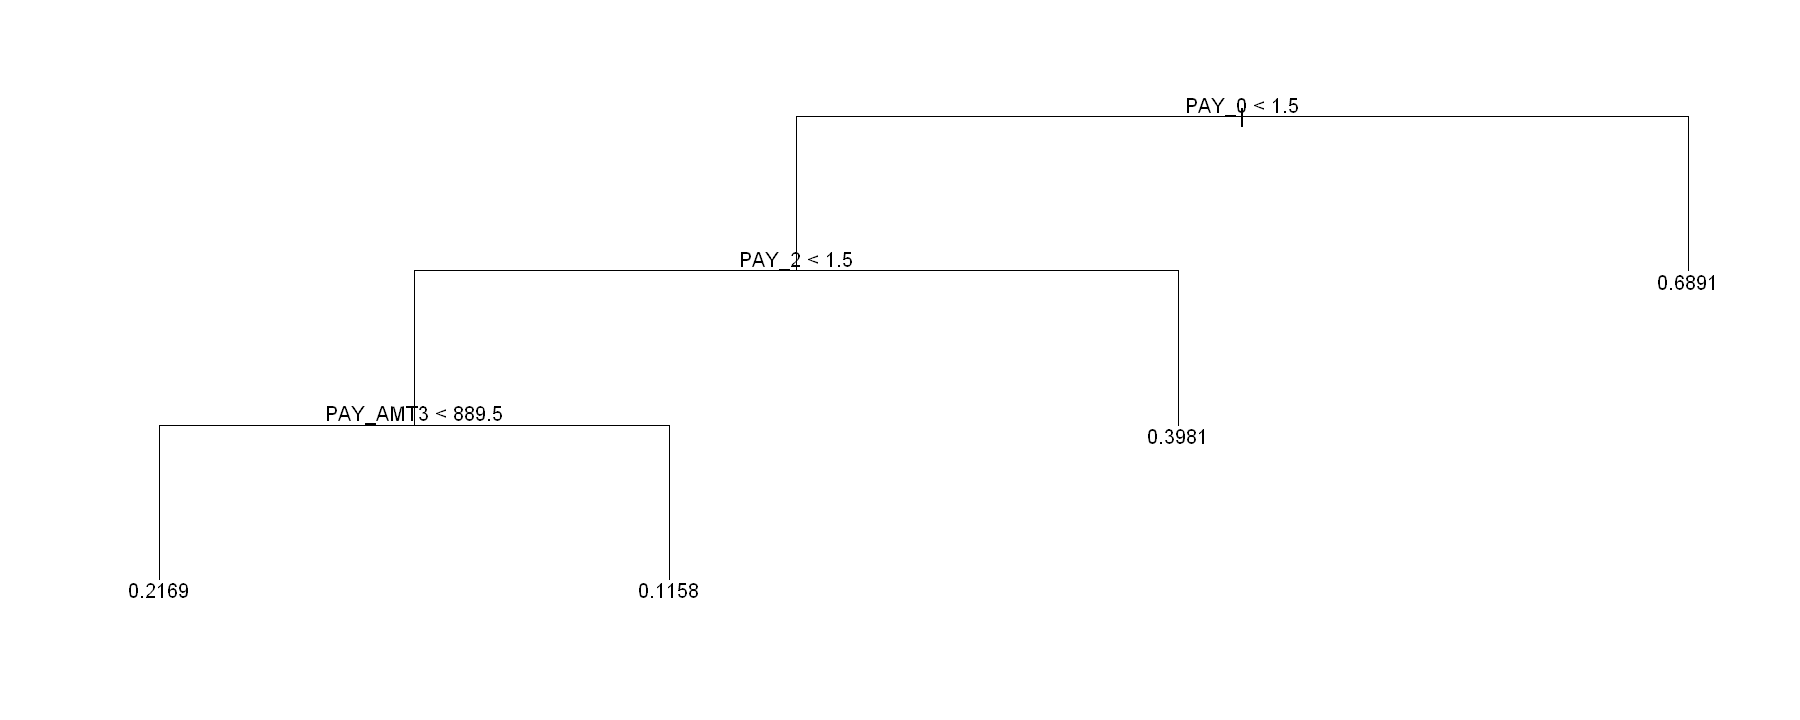

In [32]:
# Plot the regression tree
options(repr.plot.width=15, repr.plot.height=6)
plot(md_regtree, type='uniform')
text(md_regtree, pretty=0)

In [33]:
md_regtree

node), split, n, deviance, yval
      * denotes terminal node

1) root 14000 2412.0 0.2213  
  2) PAY_0 < 1.5 12556 1751.0 0.1675  
    4) PAY_2 < 1.5 11486 1432.0 0.1460  
      8) PAY_AMT3 < 889.5 3430  582.6 0.2169 *
      9) PAY_AMT3 > 889.5 8056  824.9 0.1158 *
    5) PAY_2 > 1.5 1070  256.4 0.3981 *
  3) PAY_0 > 1.5 1444  309.4 0.6891 *

In [34]:
# RSS at the root (or 1st node)
node_1 <- train
rss_node_1 <- sum((node_1$default.payment.next.month - mean(node_1$default.payment.next.month)) ^ 2)

# RSS at the first left branch (or 2nd node)
node_2 <- node_1[node_1$PAY_0 < 1.5, ]
rss_node_2 <- sum((node_2$default.payment.next.month - mean(node_2$default.payment.next.month)) ^ 2)

# RSS at the first right branch (or 3rd node)
node_3 <- node_1[node_1$PAY_0 > 1.5, ]
rss_node_3 <- sum((node_3$default.payment.next.month - mean(node_3$default.payment.next.month)) ^ 2)

# Compare RSS
print(paste("Root:", round(rss_node_1, 4)))  # Max RSS, root (no split)
print(paste("1st left branch:", round(rss_node_2, 4)))  # First split, left branch
print(paste("1st right branch:", round(rss_node_3, 4)))  # Second split, right branch

[1] "Root: 2412.4569"
[1] "1st left branch: 1750.7693"
[1] "1st right branch: 309.3871"


In [35]:
# Prune the Regression Tree #Cross Validation (delete one by one) -->
set.seed(1)
cv_regtree <- cv.tree(md_regtree)
cv_regtree

$size
[1] 4 3 2 1

$dev
[1] 1986.953 1999.424 2060.665 2412.504

$k
[1]      -Inf  24.58708  62.22144 352.30046

$method
[1] "deviance"

attr(,"class")
[1] "prune"         "tree.sequence"

In [36]:
# Best tree size
min_idx <- which.min(cv_regtree$dev)
tree_size <- cv_regtree$size[min_idx]
tree_dev <- cv_regtree$dev[min_idx]
tree_k <- cv_regtree$k[min_idx]

print(paste0('Best tree size = ', tree_size))
print(paste0('Best RSS = ', tree_dev))
print(paste0('Best alpha = ', tree_k))

[1] "Best tree size = 4"
[1] "Best RSS = 1986.95258977564"
[1] "Best alpha = -Inf"


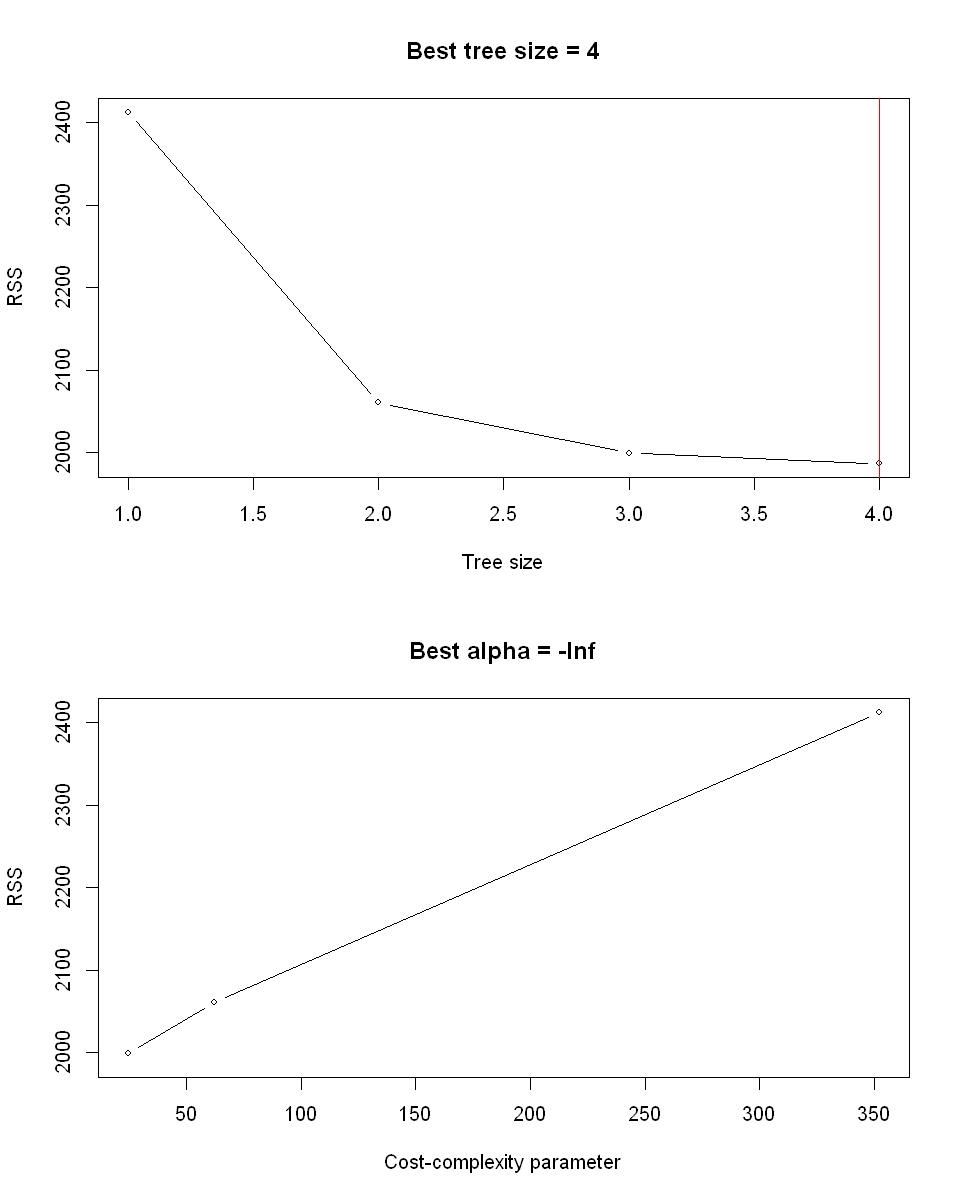

In [37]:
# Show the Decision Tree
options(repr.plot.width=8, repr.plot.height=10)
par(mfrow=c(2, 1))

# Tree size, number of nodes
plot(cv_regtree$size, cv_regtree$dev, type='b', cex=0.7,
     xlab='Tree size', ylab='RSS', main=paste0('Best tree size = ', tree_size)
    )
abline(v=tree_size, col='red')  # Best tree size

# Cost-complexity param, alpha
plot(cv_regtree$k, cv_regtree$dev, type='b', cex=0.7,
     xlab='Cost-complexity parameter', ylab='RSS',
     main=paste0('Best alpha = ', round(tree_k, 3))
    )
abline(v=tree_k, col='red')  # Best tree size

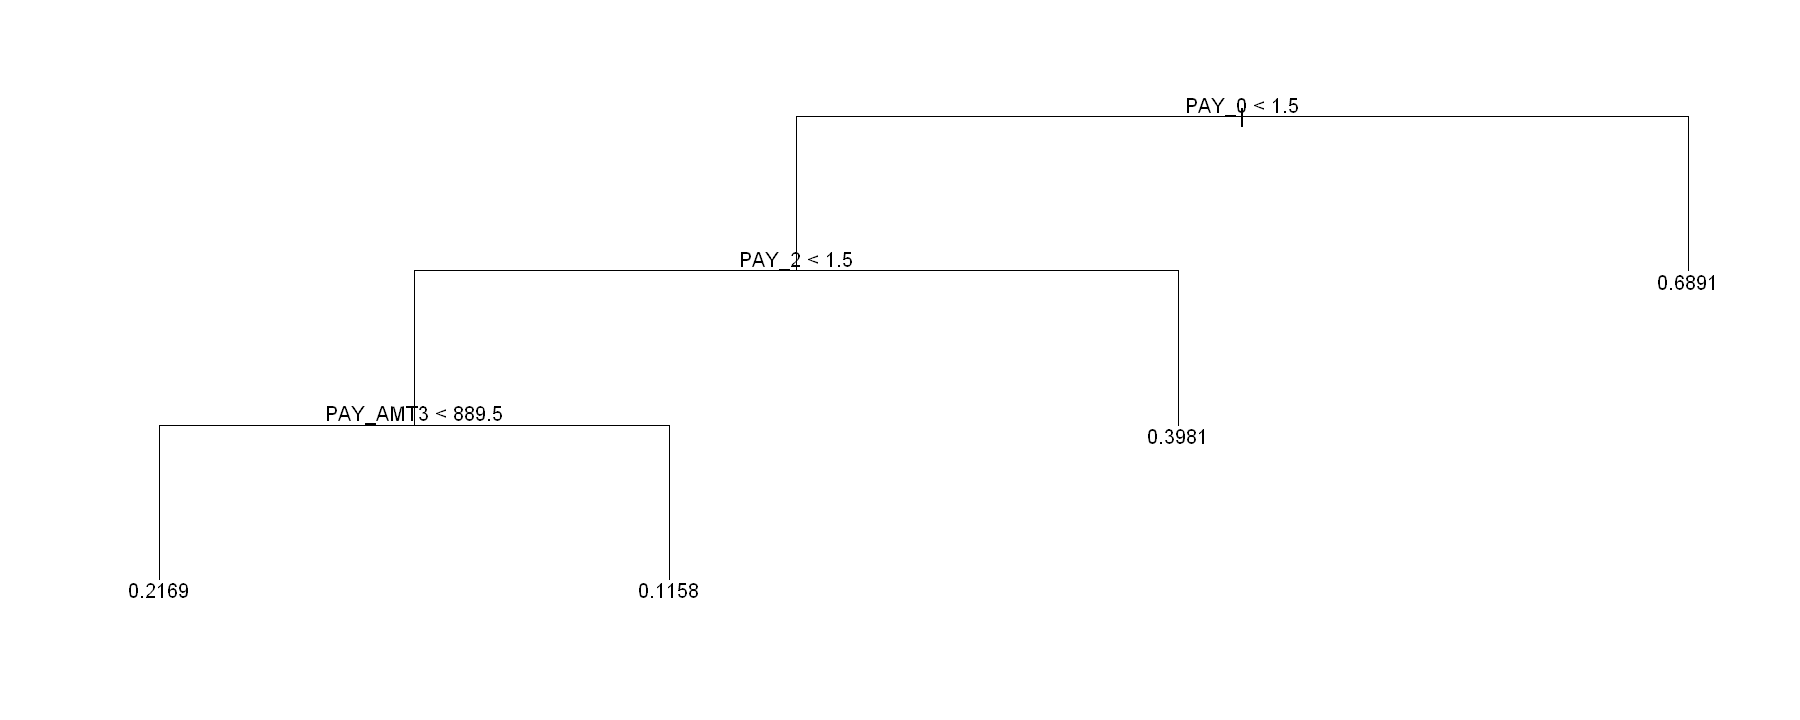

In [38]:
# Prune the tree
prune_regtree <- prune.tree(md_regtree, best=4)

# Show the tree
options(repr.plot.width=15, repr.plot.height=6)
plot(prune_regtree, type='uniform')
text(prune_regtree, pretty=0)

In [39]:
# RSS full Regression Tree
pred_full_regtree <- predict(md_regtree, newdata=test)
pred_full_regtree_f <- ifelse(pred_full_regtree > 0.5,1,0)
    
mse_full_regtree <- mean((pred_full_regtree - mean(test$default.payment.next.month)) ^ 2)
mse_full_regtree

# RSS pruned Regression Tree
pred_pruned_regtree <- predict(prune_regtree, newdata=test)
pred_pruned_regtree_f <- ifelse(pred_pruned_regtree > 0.5,1,0)

mse_pruned_regtree <- mean((pred_pruned_regtree - mean(test$default.payment.next.month)) ^ 2)
mse_pruned_regtree

[1] 0.03059304

[1] 0.03059304

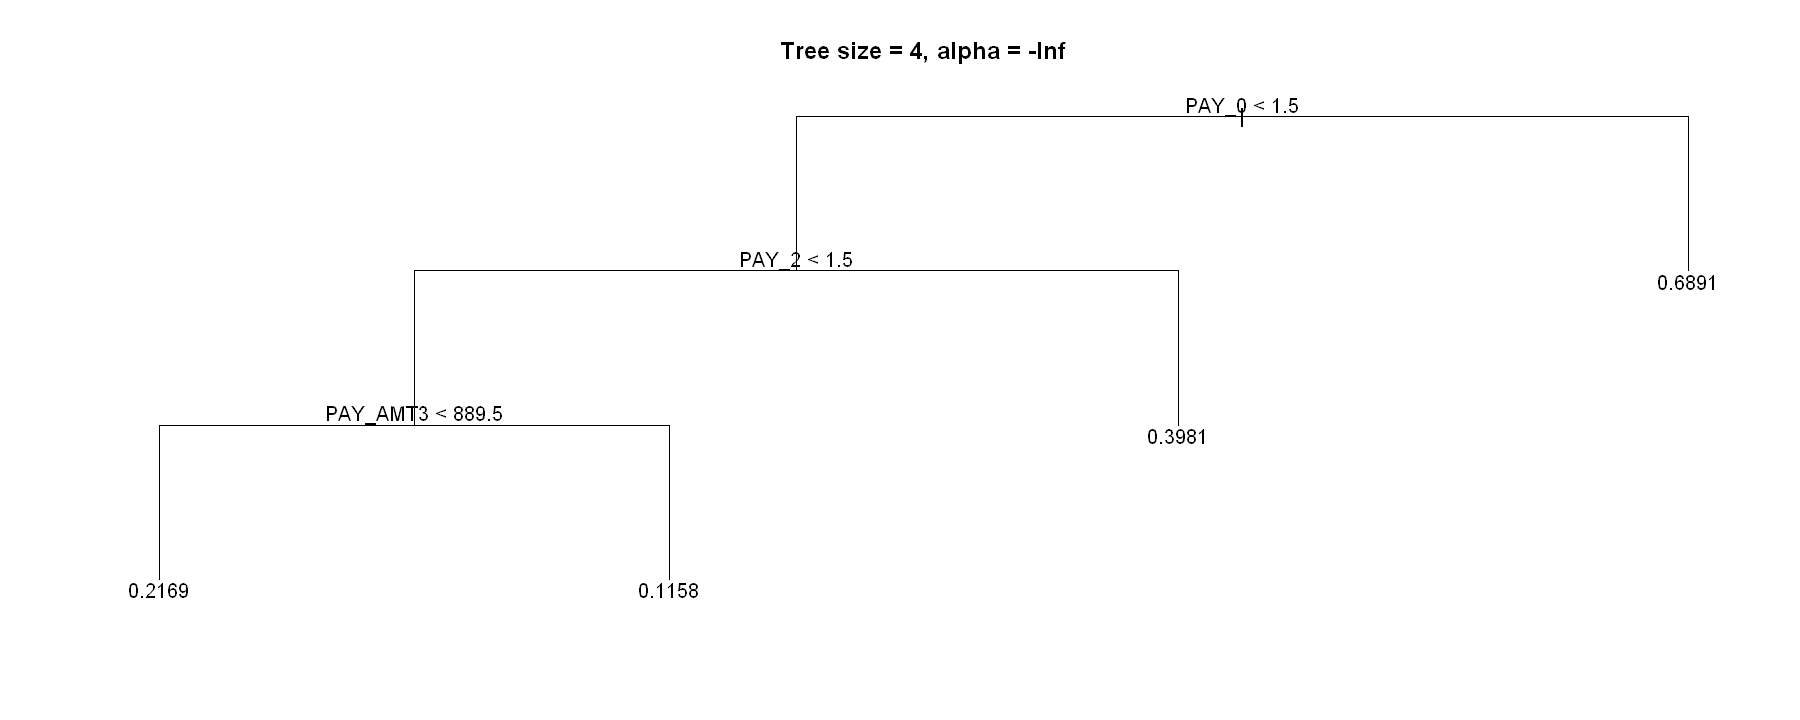

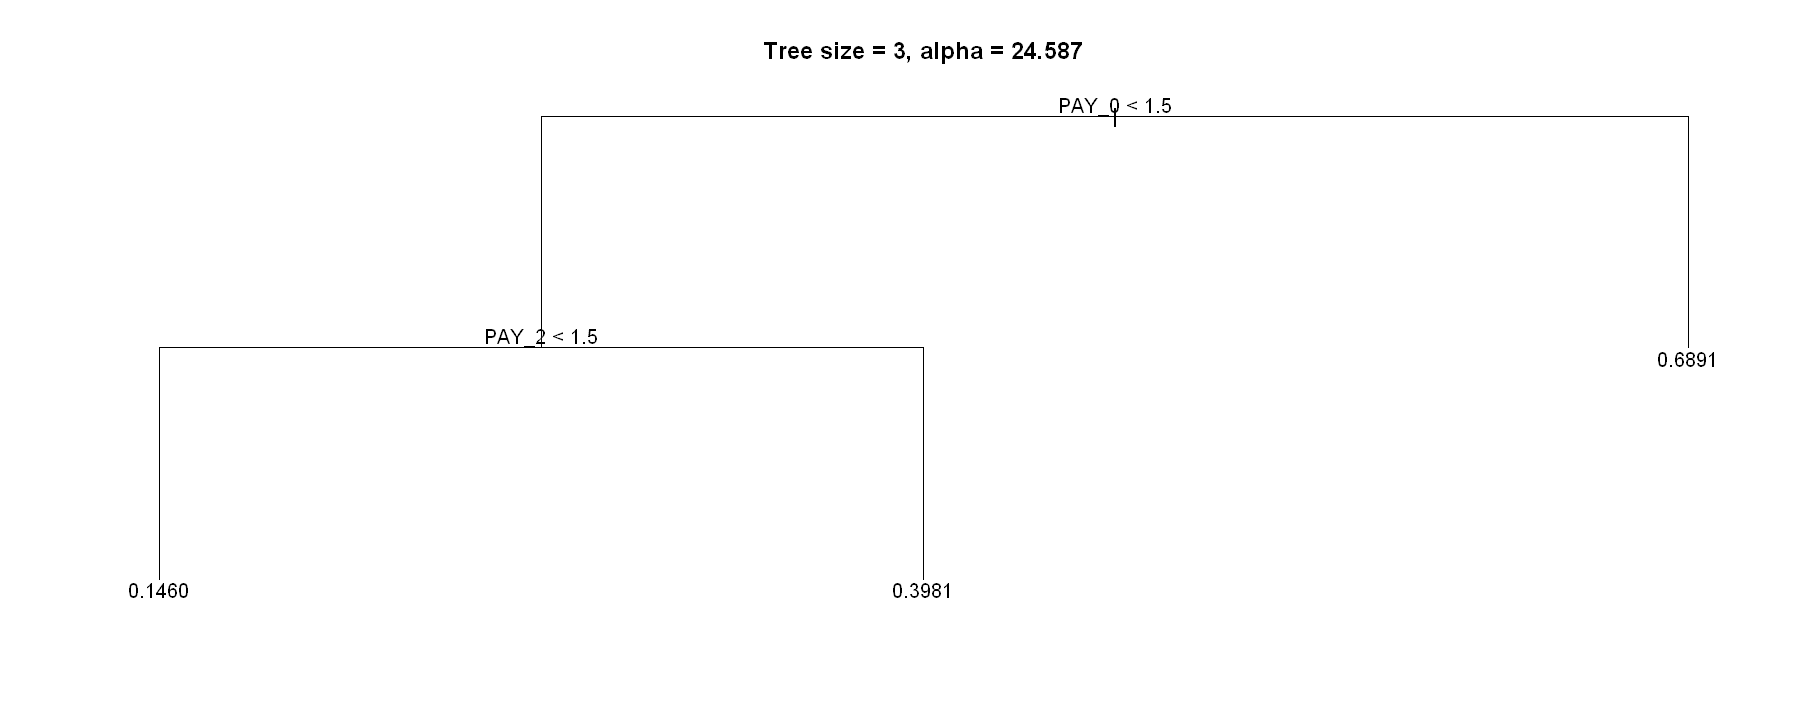

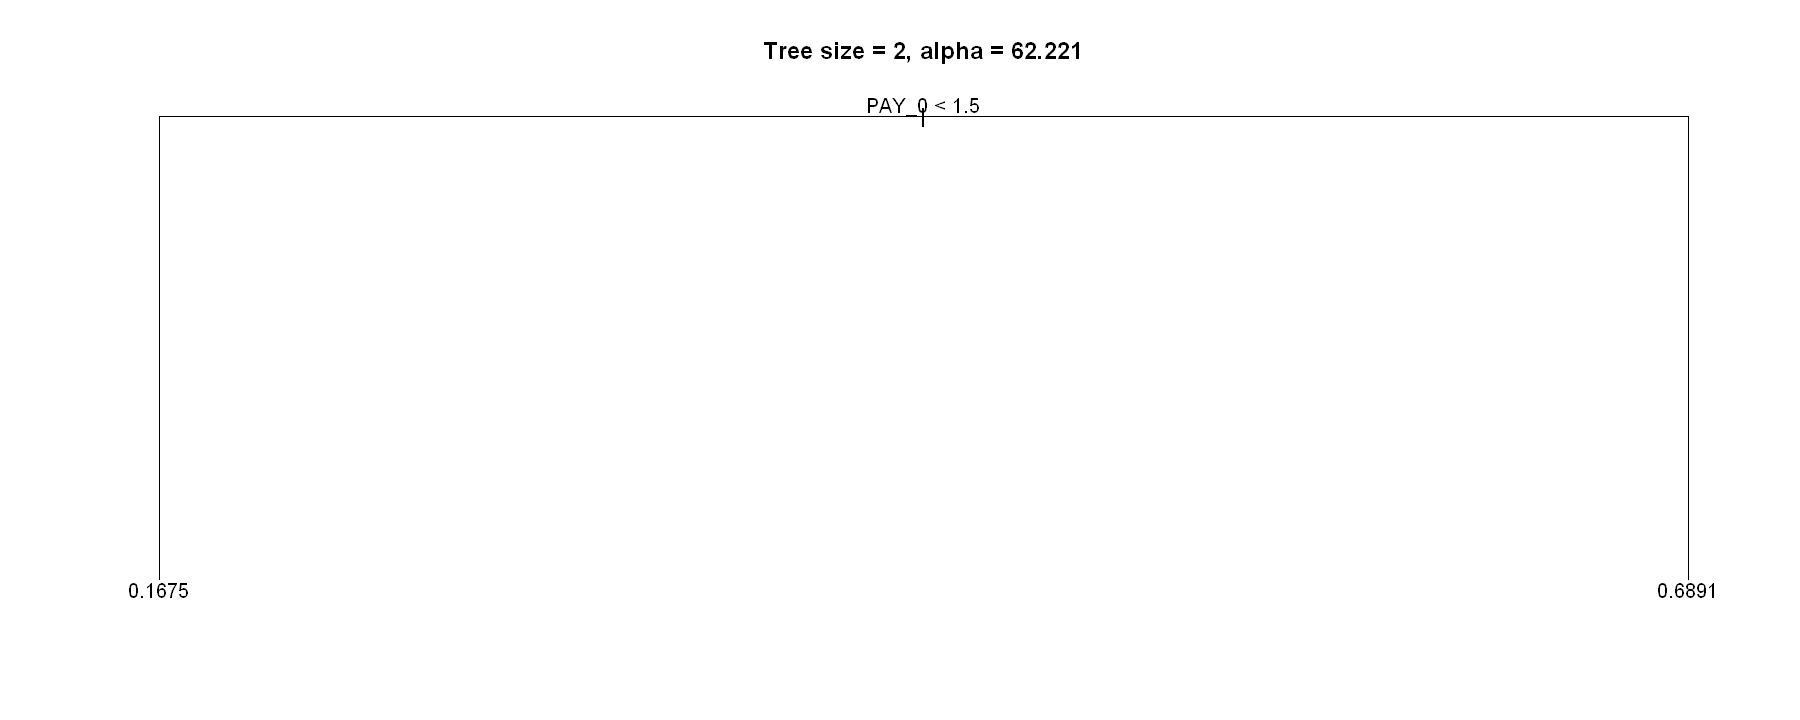

In [40]:
for (i in 1:(length(cv_regtree$size)-1)) {
    
    # Prune the tree
    tree_size = cv_regtree$size[i]
    alpha = cv_regtree$k[i]
    prune_regtree_temp <- prune.tree(md_regtree, best=tree_size)

    # Show the tree
    plot(prune_regtree_temp, type='uniform')
    text(prune_regtree_temp, pretty=0)
    title(main=paste0('Tree size = ', tree_size, ', alpha = ', round(alpha, 3)))
    }

In [41]:
# RSS full Regression Tree
pred_tr_full_regtree <- predict(md_regtree, newdata=train)
pred_tr_full_regtree_f <- ifelse(pred_tr_full_regtree > 0.5,1,0)

# RSS pruned Regression Tree
pred_tr_pruned_regtree <- predict(prune_regtree, newdata=train)
pred_tr_pruned_regtree_f <- ifelse(pred_tr_pruned_regtree > 0.5,1,0)

# RSS full Regression Tree
# Evaluation: confusion matrix
table(pred_tr_full_regtree_f, train$default.payment.next.month)

# Accuracy
print(paste0('Accuracy = ', Accuracy(pred_tr_full_regtree_f, train$default.payment.next.month)))

# AUC
print(paste0('AUC = ', pROC::auc(pROC::roc(train$default.payment.next.month, pred_tr_full_regtree_f))))

# RSS pruned Regression Tree
# Evaluation: confusion matrix
table(pred_tr_pruned_regtree_f, train$default.payment.next.month)

# Accuracy
print(paste0('Accuracy = ', Accuracy(pred_tr_pruned_regtree_f, train$default.payment.next.month)))

# AUC
print(paste0('AUC = ', pROC::auc(pROC::roc(train$default.payment.next.month, pred_tr_pruned_regtree_f))))

                      
pred_tr_full_regtree_f     0     1
                     0 10453  2103
                     1   449   995

[1] "Accuracy = 0.817714285714286"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.63999492396548"


                        
pred_tr_pruned_regtree_f     0     1
                       0 10453  2103
                       1   449   995

[1] "Accuracy = 0.817714285714286"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.63999492396548"


In [42]:
# Evaluation: confusion matrix
table(pred_full_regtree_f, test$default.payment.next.month)

# Accuracy
print(paste0('Accuracy = ', Accuracy(pred_full_regtree_f, test$default.payment.next.month)))

# AUC
print(paste0('AUC = ', pROC::auc(pROC::roc(test$default.payment.next.month, pred_full_regtree_f))))

                   
pred_full_regtree_f    0    1
                  0 4489  911
                  1  195  405

[1] "Accuracy = 0.815666666666667"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.633059837667647"


In [43]:
# Evaluation: confusion matrix
table(pred_pruned_regtree_f, test$default.payment.next.month)

# Accuracy
print(paste0('Accuracy = ', Accuracy(pred_pruned_regtree_f, test$default.payment.next.month)))

# AUC
print(paste0('AUC = ', pROC::auc(pROC::roc(test$default.payment.next.month, pred_pruned_regtree_f))))

                     
pred_pruned_regtree_f    0    1
                    0 4489  911
                    1  195  405

[1] "Accuracy = 0.815666666666667"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.633059837667647"


#### 1.3c Boosting Tree

In [44]:
# Fit boosting tree
set.seed(1)
md_boosttree <- gbm(default.payment.next.month ~ ., data=train,
                    distribution='gaussian',
                    n.trees=5000,  # Number of boosting iteration #stable
                    interaction.depth=4)  # Maximum nodes per tree #flexibility

In [45]:
# Make prediction
pred <- predict(md_boosttree, newdata=test, n.trees=5000)

# MSE
mean((pred - test$default.payment.next.month) ^ 2)

[1] 0.157376

In [46]:
# Fit boosting model with different shrinkage param, default alpha = 0.001 #shrinkage=lumda
set.seed(3)
md_boosttree <- gbm(default.payment.next.month ~ ., data=train, distribution='gaussian',
                    n.trees=5000, interaction.depth=4, shrinkage=0.01,
                    verbose=F)

# Make prediction
pred_boost <- predict(md_boosttree, newdata=test, n.trees=5000)

# Evaluation: MSE
mean((pred_boost - test$default.payment.next.month) ^ 2)

[1] 0.1373909

,var,rel.inf
,<chr>,<dbl>
PAY_0,PAY_0,28.4645583
cust_id,cust_id,6.5455623
BILL_AMT1,BILL_AMT1,5.5127818
LIMIT_BAL,LIMIT_BAL,4.6869408
PAY_AMT1,PAY_AMT1,4.3115046
PAY_2,PAY_2,4.2376750
BILL_AMT2,BILL_AMT2,3.6661558
PAY_AMT2,PAY_AMT2,3.6305612
AGE,AGE,3.4800706


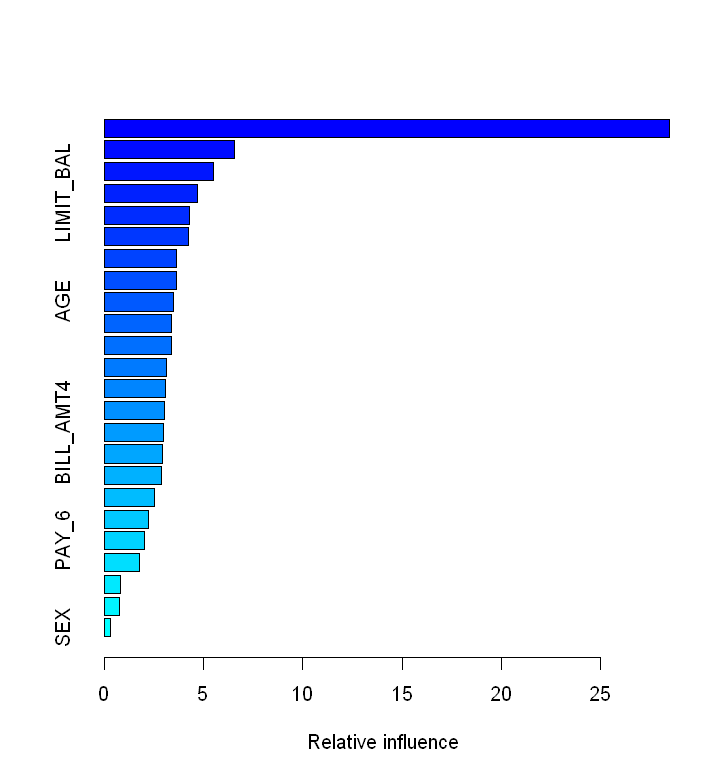

In [47]:
options(repr.plot.width=6, repr.plot.height=6.5)
summary(md_boosttree)

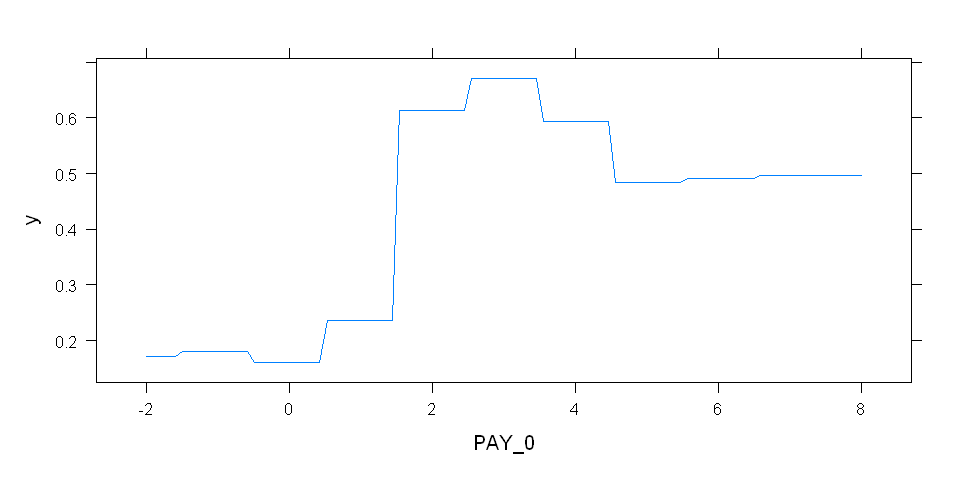

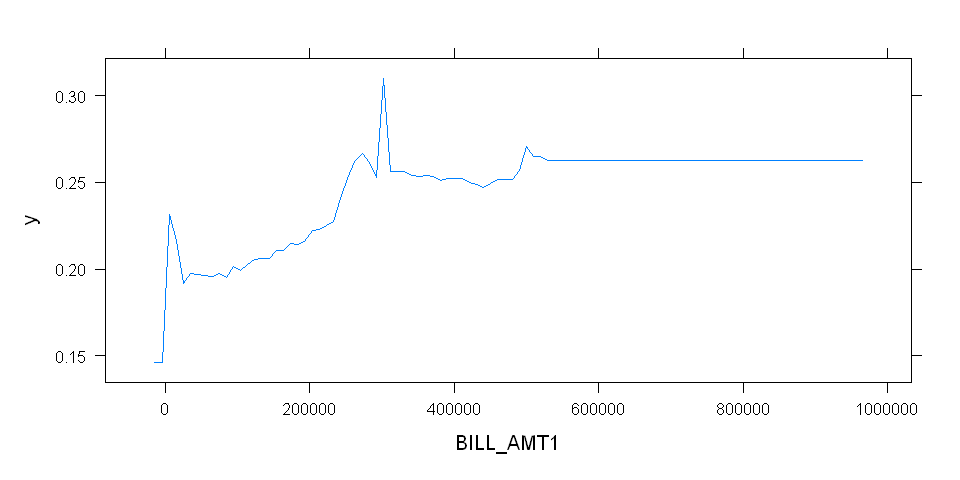

In [48]:
# Partial dependence plots
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(2, 1))
plot(md_boosttree, i='PAY_0')
plot(md_boosttree, i='BILL_AMT1')

In [49]:
# Make prediction
pred_tr_boost <- predict(md_boosttree, newdata=train, n.trees=5000)
pred_tr_boost_1 <- ifelse(pred_tr_boost > 0.5,1,0)

# Evaluation: confusion matrix
table(pred_tr_boost_1, train$default.payment.next.month)

# Accuracy
print(paste0('Accuracy = ', Accuracy(pred_tr_boost_1, train$default.payment.next.month)))

# AUC
print(paste0('AUC = ', pROC::auc(pROC::roc(train$default.payment.next.month, pred_tr_boost_1))))

               
pred_tr_boost_1     0     1
              0 10484  1834
              1   418  1264

[1] "Accuracy = 0.839142857142857"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.684831787961508"


In [50]:
pred_boost_1 <- ifelse(pred_boost > 0.5,1,0)

# Evaluation: confusion matrix
table(pred_boost_1, test$default.payment.next.month)

# Accuracy
print(paste0('Accuracy = ', Accuracy(pred_boost_1, test$default.payment.next.month)))

# AUC
print(paste0('AUC = ', pROC::auc(pROC::roc(test$default.payment.next.month, pred_boost_1))))

            
pred_boost_1    0    1
           0 4451  855
           1  233  461

[1] "Accuracy = 0.818666666666667"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.650280071328639"


#### 1.4c Boosting Tree - Feature Selection

In [51]:
# Feature Selection - Top 5 Highest Relative Influence
set.seed(3)
md_boosttree_1 <- gbm(default.payment.next.month ~ PAY_0 + BILL_AMT1 + LIMIT_BAL + PAY_AMT1 + PAY_2, data=train, distribution='gaussian',
                    n.trees=5000, interaction.depth=4, shrinkage=0.01,
                    verbose=F)

# Make prediction
pred_adj_boost <- predict(md_boosttree_1, newdata=test, n.trees=5000)

# Evaluation: MSE
mean((pred_adj_boost - test$default.payment.next.month) ^ 2)

[1] 0.1404778

In [52]:
# Make prediction
pred_adj_tr_boost <- predict(md_boosttree_1, newdata=train, n.trees=5000)
pred_adj_tr_boost_1 <- ifelse(pred_adj_tr_boost > 0.5,1,0)

# Evaluation: confusion matrix
table(pred_adj_tr_boost_1, train$default.payment.next.month)

# Accuracy
print(paste0('Accuracy = ', Accuracy(pred_adj_tr_boost_1, train$default.payment.next.month)))

# AUC
print(paste0('AUC = ', pROC::auc(pROC::roc(train$default.payment.next.month, pred_adj_tr_boost_1))))

                   
pred_adj_tr_boost_1     0     1
                  0 10455  1991
                  1   447  1107

[1] "Accuracy = 0.825857142857143"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.658162828433705"


In [53]:
pred_adj_boost_1 <- ifelse(pred_adj_boost > 0.5,1,0)

# Evaluation: confusion matrix
table(pred_adj_boost_1, test$default.payment.next.month)

# Accuracy
print(paste0('Accuracy = ', Accuracy(pred_adj_boost_1, test$default.payment.next.month)))

# AUC
print(paste0('AUC = ', pROC::auc(pROC::roc(test$default.payment.next.month, pred_adj_boost_1))))

                
pred_adj_boost_1    0    1
               0 4468  882
               1  216  434

[1] "Accuracy = 0.817"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.641836400966622"


#### 1.5c Boosting Tree - Cross Validation

In [54]:
train_control <- trainControl(method = "cv", number = 10)

# train the model on training set
model <- caret::train(as.factor(default.payment.next.month) ~ PAY_0 + BILL_AMT1 + LIMIT_BAL + PAY_AMT1 + PAY_2,
               data = train,
               trControl = train_control,
               method = "gbm")

# print cv result
model

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0292             nan     0.1000    0.0138
     2        1.0070             nan     0.1000    0.0102
     3        0.9913             nan     0.1000    0.0079
     4        0.9796             nan     0.1000    0.0059
     5        0.9684             nan     0.1000    0.0059
     6        0.9591             nan     0.1000    0.0046
     7        0.9513             nan     0.1000    0.0039
     8        0.9450             nan     0.1000    0.0032
     9        0.9392             nan     0.1000    0.0027
    10        0.9342             nan     0.1000    0.0024
    20        0.9113             nan     0.1000    0.0007
    40        0.8965             nan     0.1000    0.0001
    60        0.8911             nan     0.1000    0.0000
    80        0.8883             nan     0.1000   -0.0000
   100        0.8860             nan     0.1000    0.0000
   120        0.8846             nan     0.1000   -0.0001
   140        

Stochastic Gradient Boosting 

14000 samples
    5 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 12600, 12599, 12600, 12600, 12600, 12600, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  Accuracy   Kappa    
  1                   50      0.8159289  0.3320898
  1                  100      0.8156435  0.3395711
  1                  150      0.8162148  0.3437941
  2                   50      0.8174293  0.3466710
  2                  100      0.8177150  0.3517483
  2                  150      0.8170009  0.3506044
  3                   50      0.8175010  0.3475417
  3                  100      0.8167150  0.3478111
  3                  150      0.8172865  0.3514140

Tuning parameter 'shrinkage' was held constant at a value of 0.1

Tuning parameter 'n.minobsinnode' was held constant at a value of 10
Accuracy was used to select the optimal model using the largest value.
The final values used

In [55]:
# Feature Selection - Top 5 Highest Relative Influence
set.seed(3)
md_boosttree_1 <- gbm(default.payment.next.month ~ PAY_0 + BILL_AMT1 + LIMIT_BAL + PAY_AMT1 + PAY_2, data=train, distribution='gaussian',
                    n.trees=150, interaction.depth=3, shrinkage=0.01,
                    verbose=F)

# Make prediction
pred_adj_boost <- predict(md_boosttree_1, newdata=test, n.trees=150)

# Evaluation: MSE
mean((pred_adj_boost - test$default.payment.next.month) ^ 2)

[1] 0.1423956

In [56]:
# Make prediction
pred_adj_tr_boost <- predict(md_boosttree_1, newdata=train, n.trees=150)
pred_adj_tr_boost_1 <- ifelse(pred_adj_tr_boost > 0.5,1,0)

# Evaluation: confusion matrix
table(pred_adj_tr_boost_1, train$default.payment.next.month)

# Accuracy
print(paste0('Accuracy = ', Accuracy(pred_adj_tr_boost_1, train$default.payment.next.month)))

# AUC
print(paste0('AUC = ', pROC::auc(pROC::roc(train$default.payment.next.month, pred_adj_tr_boost_1))))

                   
pred_adj_tr_boost_1     0     1
                  0 10453  2103
                  1   449   995

[1] "Accuracy = 0.817714285714286"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.63999492396548"


In [57]:
pred_adj_boost_1 <- ifelse(pred_adj_boost > 0.5,1,0)

# Evaluation: confusion matrix
table(pred_adj_boost_1, test$default.payment.next.month)

# Accuracy
print(paste0('Accuracy = ', Accuracy(pred_adj_boost_1, test$default.payment.next.month)))

# AUC
print(paste0('AUC = ', pROC::auc(pROC::roc(test$default.payment.next.month, pred_adj_boost_1))))

                
pred_adj_boost_1    0    1
               0 4489  911
               1  195  405

[1] "Accuracy = 0.815666666666667"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.633059837667647"


#### 1.3d Random Forest

In [58]:
# Fit random forests model
md_rf <- randomForest(default.payment.next.month ~ ., data=train, mtry=3, importance=T)
md_rf

Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"



Call:
 randomForest(formula = default.payment.next.month ~ ., data = train,      mtry = 3, importance = T) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 3

          Mean of squared residuals: 0.1376118
                    % Var explained: 20.14

[1] 0.1384572

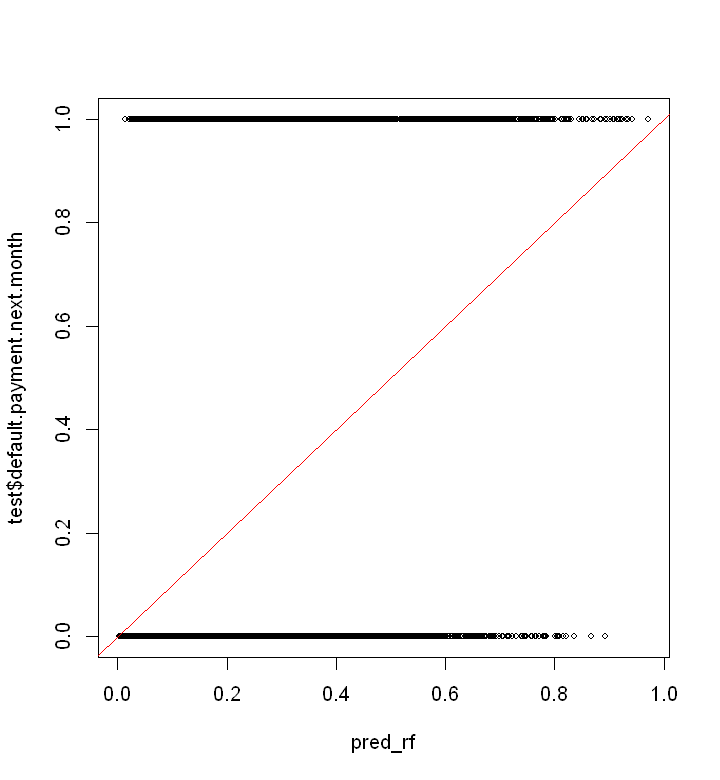

In [59]:
# Make prediction
pred_rf <- predict(md_rf, newdata=test)

options(repr.plot.width=6, repr.plot.height=6.5)
plot(pred_rf, test$default.payment.next.month, cex=0.7)
abline(0, 1, col='red')

# MSE
mean((pred_rf - test$default.payment.next.month) ^ 2)

In [60]:
# Feature importance
importance(md_rf)

,%IncMSE,IncNodePurity
cust_id,0.9005533,128.11856
LIMIT_BAL,22.9321722,103.46662
SEX,1.0066648,18.67297
EDUCATION,0.8478667,34.41012
MARRIAGE,8.5456015,23.65765
AGE,11.5743680,103.37701
PAY_0,85.7663301,202.49115
PAY_2,38.4413595,93.02556
PAY_3,34.6592547,62.22638
PAY_4,34.9769288,58.84175


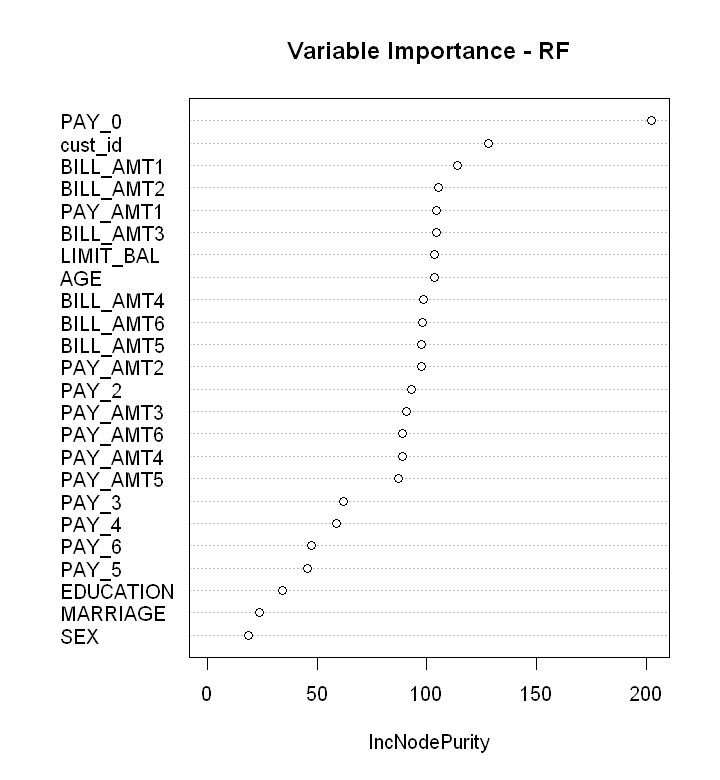

In [61]:
# Plot feature importance
options(repr.plot.width=6, repr.plot.height=6.5)
varImpPlot(md_rf, type=2, main='Variable Importance - RF')

In [62]:
# Make prediction
pred_tr_rf <- predict(md_rf, newdata=train)
pred_tr_rf_1 <- ifelse(pred_tr_rf > 0.5,1,0)

# Evaluation: confusion matrix
table(pred_tr_rf_1, train$default.payment.next.month)

# Accuracy
print(paste0('Accuracy = ', Accuracy(pred_tr_rf_1, train$default.payment.next.month)))

# AUC
print(paste0('AUC = ', pROC::auc(pROC::roc(train$default.payment.next.month, pred_tr_rf_1))))

            
pred_tr_rf_1     0     1
           0 10891   110
           1    11  2988

[1] "Accuracy = 0.991357142857143"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.981742116128442"


In [63]:
pred_rf_1 <- ifelse(pred_rf > 0.5,1,0)

# Evaluation: confusion matrix
table(pred_rf_1, test$default.payment.next.month)

# Accuracy
print(paste0('Accuracy = ', Accuracy(pred_rf_1, test$default.payment.next.month)))

# AUC
print(paste0('AUC = ', pROC::auc(pROC::roc(test$default.payment.next.month, pred_rf_1))))

         
pred_rf_1    0    1
        0 4426  867
        1  258  449

[1] "Accuracy = 0.8125"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.643052141546336"


In [64]:
#### Overfitting

#### 1.4d Random Forest - Variable selection based on Feature Importance

In [65]:
# Fit random forests model
md_rf1 <- randomForest(default.payment.next.month ~ PAY_0 + BILL_AMT1 + BILL_AMT2 + AGE + LIMIT_BAL, data=train, mtry=2, importance=T)
md_rf1

Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"



Call:
 randomForest(formula = default.payment.next.month ~ PAY_0 + BILL_AMT1 +      BILL_AMT2 + AGE + LIMIT_BAL, data = train, mtry = 2, importance = T) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 2

          Mean of squared residuals: 0.1485149
                    % Var explained: 13.81

[1] 0.1482033

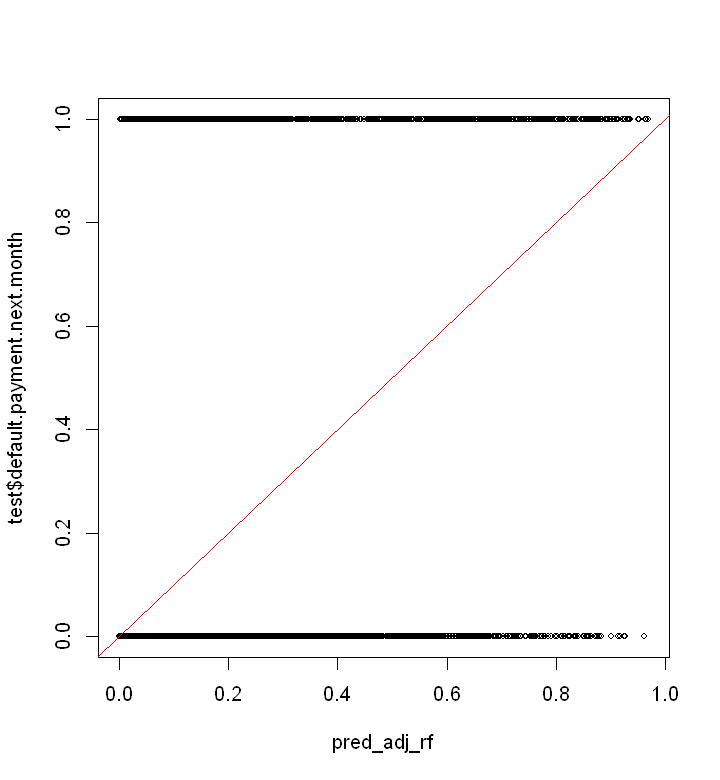

In [66]:
# Make prediction
pred_adj_rf <- predict(md_rf1, newdata=test)

options(repr.plot.width=6, repr.plot.height=6.5)
plot(pred_adj_rf, test$default.payment.next.month, cex=0.7)
abline(0, 1, col='red')

# MSE
mean((pred_adj_rf - test$default.payment.next.month) ^ 2)

In [67]:
# Make prediction
pred_adj_tr_rf <- predict(md_rf1, newdata=train)
pred_adj_tr_rf_1 <- ifelse(pred_adj_tr_rf > 0.5,1,0)

# Evaluation: confusion matrix
table(pred_adj_tr_rf_1, train$default.payment.next.month)

# Accuracy
print(paste0('Accuracy = ', Accuracy(pred_adj_tr_rf_1, train$default.payment.next.month)))

# AUC
print(paste0('AUC = ', pROC::auc(pROC::roc(train$default.payment.next.month, pred_adj_tr_rf_1))))

                
pred_adj_tr_rf_1     0     1
               0 10879   388
               1    23  2710

[1] "Accuracy = 0.970642857142857"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.936324101843302"


In [68]:
pred_adj_rf1 <- ifelse(pred_adj_rf > 0.5,1,0)

# Evaluation: confusion matrix
table(pred_adj_rf1, test$default.payment.next.month)

# Accuracy
print(paste0('Accuracy = ', Accuracy(pred_adj_rf1, test$default.payment.next.month)))

# AUC
print(paste0('AUC = ', pROC::auc(pROC::roc(test$default.payment.next.month, pred_adj_rf1))))

            
pred_adj_rf1    0    1
           0 4389  868
           1  295  448

[1] "Accuracy = 0.806166666666667"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.638722586623544"


In [69]:
#### Overfitting

#### 1.5d Random Forest - Cross Validation

In [70]:
train_control <- trainControl(method = "cv", number = 10)

# train the model on training set
model <- caret::train(as.factor(default.payment.next.month) ~ PAY_0 + BILL_AMT1 + BILL_AMT2 + AGE + LIMIT_BAL,
               data = train,
               trControl = train_control,
               method = "rf")

# print cv result
model

Random Forest 

14000 samples
    5 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 12600, 12601, 12600, 12599, 12599, 12600, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  2     0.8024311  0.3204094
  3     0.7967880  0.3120268
  5     0.7926445  0.3037573

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.

#### 1.3e K-Nearest Neighbors (KNN)

In [71]:
# k = 5
set.seed(123)
knn1_pred <- knn(train=train[, iv_vars],
                 test=test[, iv_vars],
                 cl=train$default.payment.next.month,
                 k=5)

# Confusion matrix
print('Confusion matrix:')
table(knn1_pred, test$default.payment.next.month)

# Accuracy
acc <- mean(knn1_pred == test$default.payment.next.month)
print(paste('Accuracy =', round(acc, 6), '%'))

# AUC
pred_roc <- pROC::roc(knn1_pred, test$default.payment.next.month)
pred_auc <- pROC::auc(pred_roc)
print(paste('AUC =', pred_auc))

[1] "Confusion matrix:"


         
knn1_pred    0    1
        0 4271 1087
        1  413  229

[1] "Accuracy = 0.75 %"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.576911806260531"


In [72]:
# k = 5
set.seed(123)
knn1_pred <- knn(train=train[, iv_vars],
                 test=train[, iv_vars],
                 cl=train$default.payment.next.month,
                 k=5)

# Confusion matrix
print('Confusion matrix:')
table(knn1_pred, train$default.payment.next.month)

# Accuracy
acc <- mean(knn1_pred == train$default.payment.next.month)
print(paste('Accuracy =', round(acc, 6), '%'))

# AUC
pred_roc <- pROC::roc(knn1_pred, train$default.payment.next.month)
pred_auc <- pROC::auc(pred_roc)
print(paste('AUC =', pred_auc))

[1] "Confusion matrix:"


         
knn1_pred     0     1
        0 10373  2102
        1   529   996

[1] "Accuracy = 0.812071 %"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.742308880055192"


#### 1.4e KNN - Feature Selection

In [73]:
# k = 5
set.seed(123)
knn2_pred <- knn(train=train[, c('PAY_0', 'PAY_AMT2')],
                 test=test[, c('PAY_0', 'PAY_AMT2')],
                 cl=train$default.payment.next.month,
                 k=5)

# Confusion matrix
print('Confusion matrix:')
table(knn2_pred, test$default.payment.next.month)

# Accuracy
acc <- mean(knn2_pred == test$default.payment.next.month)
print(paste('Accuracy =', round(acc, 6), '%'))

# AUC
pred_roc <- pROC::roc(knn2_pred, test$default.payment.next.month)
pred_auc <- pROC::auc(pred_roc)
print(paste('AUC =', pred_auc))

[1] "Confusion matrix:"


         
knn2_pred    0    1
        0 4441 1034
        1  243  282

[1] "Accuracy = 0.787167 %"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.674142204827136"


In [74]:
# k = 5
set.seed(123)
knn2_pred <- knn(train=train[, c('PAY_0', 'PAY_AMT2')],
                 test=train[, c('PAY_0', 'PAY_AMT2')],
                 cl=train$default.payment.next.month,
                 k=5)

# Confusion matrix
print('Confusion matrix:')
table(knn2_pred, train$default.payment.next.month)

# Accuracy
acc <- mean(knn2_pred == train$default.payment.next.month)
print(paste('Accuracy =', round(acc, 6), '%'))

# AUC
pred_roc <- pROC::roc(knn2_pred, train$default.payment.next.month)
pred_auc <- pROC::auc(pred_roc)
print(paste('AUC =', pred_auc))

[1] "Confusion matrix:"


         
knn2_pred     0     1
        0 10497  2184
        1   405   914

[1] "Accuracy = 0.815071 %"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.760361519406724"


#### 1.5e KNN - Cross-Validation

In [75]:
train_control <- trainControl(method = "cv", number = 10)

# train the model on training set
model <- caret::train(as.factor(default.payment.next.month) ~ PAY_0 + PAY_AMT2,
               data = train,
               trControl = train_control,
               method = "knn")

# print cv result
model

k-Nearest Neighbors 

14000 samples
    2 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 12601, 12600, 12600, 12599, 12600, 12600, ... 
Resampling results across tuning parameters:

  k  Accuracy   Kappa    
  5  0.7952870  0.2414873
  7  0.7955009  0.2321406
  9  0.7996433  0.2327442

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 9.

In [76]:
# k = 9
set.seed(123)
knn2_pred <- knn(train=train[, c('PAY_0', 'PAY_AMT2')],
                 test=test[, c('PAY_0', 'PAY_AMT2')],
                 cl=train$default.payment.next.month,
                 k=9)

# Confusion matrix
print('Confusion matrix:')
table(knn2_pred, test$default.payment.next.month)

# Accuracy
acc <- mean(knn2_pred == test$default.payment.next.month)
print(paste('Accuracy =', round(acc, 6), '%'))

# AUC
pred_roc <- pROC::roc(knn2_pred, test$default.payment.next.month)
pred_auc <- pROC::auc(pred_roc)
print(paste('AUC =', pred_auc))

[1] "Confusion matrix:"


         
knn2_pred    0    1
        0 4534 1078
        1  150  238

[1] "Accuracy = 0.795333 %"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.710656839908591"


In [77]:
# k = 9
set.seed(123)
knn2_pred <- knn(train=train[, c('PAY_0', 'PAY_AMT2')],
                 test=train[, c('PAY_0', 'PAY_AMT2')],
                 cl=train$default.payment.next.month,
                 k=9)

# Confusion matrix
print('Confusion matrix:')
table(knn2_pred, train$default.payment.next.month)

# Accuracy
acc <- mean(knn2_pred == train$default.payment.next.month)
print(paste('Accuracy =', round(acc, 6), '%'))

# AUC
pred_roc <- pROC::roc(knn2_pred, train$default.payment.next.month)
pred_auc <- pROC::auc(pred_roc)
print(paste('AUC =', pred_auc))

[1] "Confusion matrix:"


         
knn2_pred     0     1
        0 10584  2374
        1   318   724

[1] "Accuracy = 0.807714 %"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC = 0.755805186637236"
